<a href="https://colab.research.google.com/github/cianadeveau/NeuroSAE/blob/main/FeatureMapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn==1.5.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 127.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.1 which is incompatible.


In [4]:
import sklearn
print(sklearn.__version__)

1.5.1


In [47]:
## Installing some packages
import os
import sys
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import torch.nn as nn
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoFeatureExtractor, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.linear_model import RidgeCV
from torchvision import models, transforms, utils
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model._ridge import LinearModel, MultiOutputMixin, RegressorMixin
from sklearn.linear_model._ridge import _RidgeGCV, _BaseRidgeCV, RidgeCV
from sklearn.linear_model._ridge import is_classifier, check_scoring, _check_gcv_mode
from sklearn.linear_model._ridge import _IdentityRegressor, safe_sparse_dot
from sklearn.linear_model._base import _preprocess_data, _rescale_data
from sklearn.metrics import r2_score, explained_variance_score
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm

# Import Image Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
from pathlib import Path
datadir = Path('/content/drive/My Drive/Colab Notebooks/BMM/').expanduser()

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


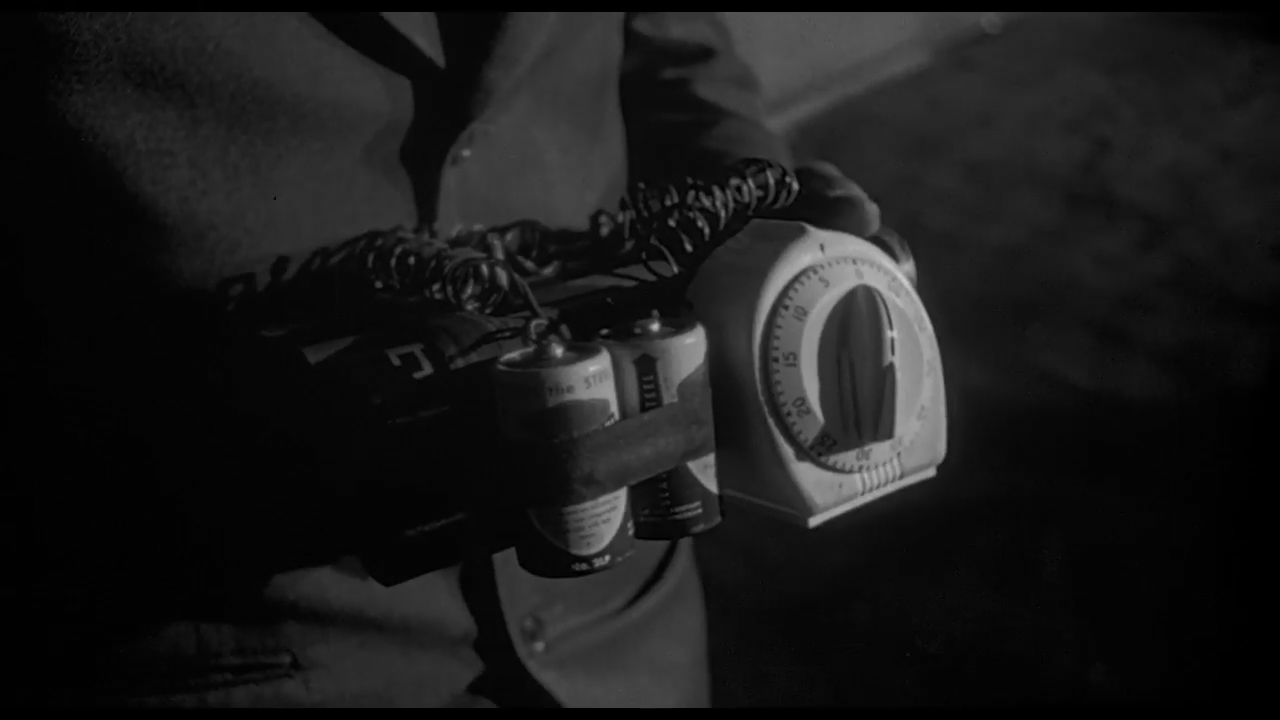

In [8]:
image = Image.open(str(datadir/'touch_of_evil/frame_38.png'))
image

In [9]:
# Load the image processor and model
image_processor = AutoImageProcessor.from_pretrained('microsoft/resnet-18')
model = AutoModelForImageClassification.from_pretrained('microsoft/resnet-18')

# Set the model to evaluation mode
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBasicLayer(
              (shortcut): Identity()
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (activation): ReLU()
           

## Run Images Through Model

In [10]:
# Load images
images = []
for i in np.arange(74,599):
  image = Image.open(str(datadir/f'touch_of_evil/frame_{i}.png'))
  if image.mode != 'RGB':
      image = image.convert('RGB')
  images.append(image)
# Preprocess the image
inputs = image_processor(images=images, return_tensors="pt")

# Perform inference
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

## First Visualization

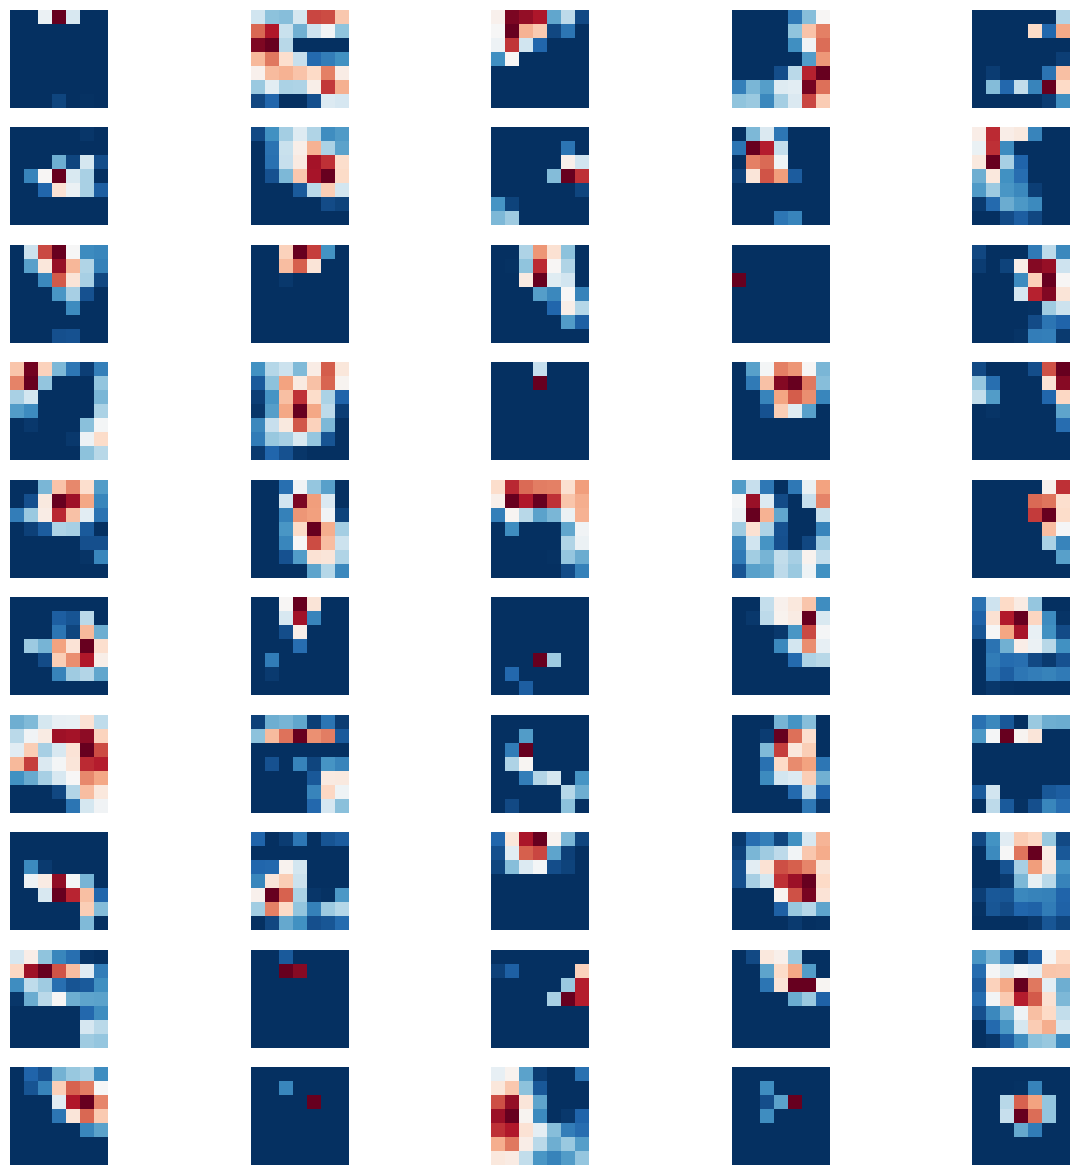

In [11]:
# Assume 'features' is the output of the last convolutional layer
# For visualization, we need to select a specific feature map (channel)

def visualize_feature_maps(feature_maps, num_cols=5):
    num_feature_maps = feature_maps.size(1)
    num_rows = (num_feature_maps + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    for i in range(num_feature_maps):
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(feature_maps[0, i].detach().numpy(), cmap='RdBu_r')
        ax.axis('off')

    plt.show()

# Use this function to visualize the feature maps
visualize_feature_maps(outputs.hidden_states[4][:,:50])

# Run Linear Regression between brain data and embeddings

## Read in brain data

In [12]:
data = np.load(datadir/'natural_movie_dff.npy', allow_pickle=True)

In [13]:
tr = 0
i = 0
data_trials = []
while i<10:
  data_trials.append(data[0][:, tr:tr+525])
  tr += 900
  i += 1

In [14]:
all_data = np.concatenate((data_trials[0], data_trials[1], data_trials[2], data_trials[3], data_trials[4], data_trials[5], data_trials[6], data_trials[7], data_trials[8], data_trials[9]), axis=1)

In [15]:
brain_data = data_trials[0].T
brain_data = all_data.T

## Select layer for embedding

In [16]:
feature_map1 = outputs.hidden_states[1]
feature_map2 = outputs.hidden_states[2]
feature_map3 = outputs.hidden_states[3]
feature_map4 = outputs.hidden_states[4]

In [17]:
flattened_feature_map1 = feature_map1.view(feature_map1.shape[0], -1).detach().numpy()
flattened_feature_map2 = feature_map2.view(feature_map2.shape[0], -1).detach().numpy()
flattened_feature_map3 = feature_map3.view(feature_map3.shape[0], -1).detach().numpy()
flattened_feature_map4 = feature_map4.view(feature_map4.shape[0], -1).detach().numpy()

In [18]:
all_layers = np.concatenate((flattened_feature_map1, flattened_feature_map2, flattened_feature_map3, flattened_feature_map4), axis=1)

In [19]:
fl1 = np.repeat(flattened_feature_map1,10, axis=0)

In [20]:
fl2 = np.repeat(flattened_feature_map2,10, axis=0)

In [21]:
fl3 = np.repeat(flattened_feature_map3,10, axis=0)

In [22]:
fl4 = np.repeat(flattened_feature_map4,10, axis=0)
fl_all = np.repeat(all_layers,10, axis=0)

## Train a Linear Layer

In [ ]:
## Use torch.RidgeCV keep on CPU DeepJuice instead of a linear layer

In [28]:
#@title Run this for RidgeGCV Code

pearsonr_vec = np.vectorize(pearsonr, signature='(n),(n)->(),()')

def pearson_r_score(y_true, y_pred, multioutput=None):
    y_true_ = y_true.transpose()
    y_pred_ = y_pred.transpose()
    return(pearsonr_vec(y_true_, y_pred_)[0])

class _RidgeGCVMod(_RidgeGCV):
    """Ridge regression with built-in Leave-one-out Cross-Validation."""

    def __init__(
        self,
        alphas=(0.1, 1.0, 10.0),
        *,
        fit_intercept=True,
        scoring=None,
        copy_X=True,
        gcv_mode=None,
        store_cv_values=False,
        is_clf=False,
        alpha_per_target=False,
    ):
        self.alphas = np.asarray(alphas)
        self.fit_intercept = fit_intercept
        self.scoring = scoring
        self.copy_X = copy_X
        self.gcv_mode = gcv_mode
        self.store_cv_values = store_cv_values
        self.is_clf = is_clf
        self.alpha_per_target = alpha_per_target
        self.cv_values_ = None

    def fit(self, X, y, sample_weight=None):
        _normalize = False

        X, y = self._validate_data(
            X,
            y,
            accept_sparse=["csr", "csc", "coo"],
            dtype=[np.float64],
            multi_output=True,
            y_numeric=True,
        )

        # alpha_per_target cannot be used in classifier mode. All subclasses
        # of _RidgeGCV that are classifiers keep alpha_per_target at its
        # default value: False, so the condition below should never happen.
        assert not (self.is_clf and self.alpha_per_target)

        if sample_weight is not None:
            sample_weight = _check_sample_weight(sample_weight, X, dtype=X.dtype)

        if np.any(self.alphas <= 0):
            raise ValueError(
                "alphas must be strictly positive. Got {} containing some "
                "negative or null value instead.".format(self.alphas)
            )

        X, y, X_offset, y_offset, X_scale = _preprocess_data(
            X=X,
            y=y,
            fit_intercept=self.fit_intercept,
            # _normalize,
            copy=self.copy_X,
            sample_weight=sample_weight,
        )

        gcv_mode = _check_gcv_mode(X, self.gcv_mode)

        if gcv_mode == "eigen":
            decompose = self._eigen_decompose_gram
            solve = self._solve_eigen_gram
        elif gcv_mode == "svd":
            if sparse.issparse(X):
                decompose = self._eigen_decompose_covariance
                solve = self._solve_eigen_covariance
            else:
                decompose = self._svd_decompose_design_matrix
                solve = self._solve_svd_design_matrix

        n_samples = X.shape[0]

        if sample_weight is not None:
            X, y = _rescale_data(X, y, sample_weight)
            sqrt_sw = np.sqrt(sample_weight)
        else:
            sqrt_sw = np.ones(n_samples, dtype=X.dtype)

        X_mean, *decomposition = decompose(X, y, sqrt_sw)

        if self.scoring not in ['pearson_r', 'explained_variance']:
            raise ValueError("modified RidgeCV scoring requires one of ['pearson_r','explained_variance']")

        n_y = 1 if len(y.shape) == 1 else y.shape[1]
        n_alphas = 1 if np.ndim(self.alphas) == 0 else len(self.alphas)

        if self.store_cv_values:
            self.cv_values_ = np.empty((n_samples * n_y, n_alphas), dtype=X.dtype)

        best_coef, best_score, best_alpha = None, None, None

        for i, alpha in enumerate(np.atleast_1d(self.alphas)):
            G_inverse_diag, c = solve(float(alpha), y, sqrt_sw, X_mean, *decomposition)
            predictions = y - (c / G_inverse_diag)
            if self.store_cv_values:
                self.cv_values_[:, i] = predictions.ravel()

            identity_estimator = _IdentityRegressor()
            if self.alpha_per_target:
                if self.scoring == 'pearson_r':
                    alpha_score = pearson_r_score(y, predictions)
                if self.scoring == 'explained_variance':
                    alpha_score = explained_variance_score(y, predictions, multioutput = 'raw_values')
            else:
                if self.scoring == 'pearson_r':
                    alpha_score = pearson_r_score(y, predictions).mean()
                if self.scoring == 'explained_variance':
                    alpha_score = explained_variance_score(y, predictions, multioutput = 'uniform_average')

            # Keep track of the best model
            if best_score is None:
                if self.alpha_per_target and n_y > 1:
                    best_coef = c
                    best_score = np.atleast_1d(alpha_score)
                    best_alpha = np.full(n_y, alpha)
                else:
                    best_coef = c
                    best_score = alpha_score
                    best_alpha = alpha
            else:
                if self.alpha_per_target and n_y > 1:
                    to_update = alpha_score > best_score
                    best_coef[:, to_update] = c[:, to_update]
                    best_score[to_update] = alpha_score[to_update]
                    best_alpha[to_update] = alpha
                elif alpha_score > best_score:
                    best_coef, best_score, best_alpha = c, alpha_score, alpha

        self.alpha_ = best_alpha
        self.best_score_ = best_score
        self.dual_coef_ = best_coef
        self.coef_ = safe_sparse_dot(self.dual_coef_.T, X)

        X_offset += X_mean * X_scale
        self._set_intercept(X_offset, y_offset, X_scale)

        if self.store_cv_values:
            if len(y.shape) == 1:
                cv_values_shape = n_samples, n_alphas
            else:
                cv_values_shape = n_samples, n_y, n_alphas
            self.cv_values_ = self.cv_values_.reshape(cv_values_shape)

        return self


class _BaseRidgeCVMod(_BaseRidgeCV):

    def fit(self, X, y, sample_weight=None):
        cv = self.cv
        if cv is None:
            estimator = _RidgeGCVMod(
                self.alphas,
                fit_intercept=self.fit_intercept,
                scoring=self.scoring,
                gcv_mode=self.gcv_mode,
                store_cv_values=self.store_cv_values,
                is_clf=is_classifier(self),
                alpha_per_target=self.alpha_per_target,
            )
            estimator.fit(X, y, sample_weight=sample_weight)
            print(estimator.cv_values_)
            self.alpha_ = estimator.alpha_
            self.best_score_ = estimator.best_score_
            # if self.store_cv_values:
            self.cv_results_ = estimator.cv_values_
        else:
            if self.store_cv_values:
                raise ValueError("cv!=None and store_cv_values=True are incompatible")
            if self.alpha_per_target:
                raise ValueError("cv!=None and alpha_per_target=True are incompatible")
            parameters = {"alpha": self.alphas}
            solver = "sparse_cg" if sparse.issparse(X) else "auto"
            model = RidgeClassifier if is_classifier(self) else Ridge
            gs = GridSearchCV(
                model(
                    fit_intercept=self.fit_intercept,
                    solver=solver,
                ),
                parameters,
                cv=cv,
                scoring=self.scoring,
            )
            gs.fit(X, y, sample_weight=sample_weight)
            estimator = gs.best_estimator_
            self.alpha_ = gs.best_estimator_.alpha
            self.best_score_ = gs.best_score_

        self.coef_ = estimator.coef_
        self.intercept_ = estimator.intercept_
        self.n_features_in_ = estimator.n_features_in_
        if hasattr(estimator, "feature_names_in_"):
            self.feature_names_in_ = estimator.feature_names_in_

        return self

class RidgeCVMod(MultiOutputMixin, RegressorMixin, _BaseRidgeCVMod):
    """Ridge regression with built-in cross-validation."""

In [29]:
def get_splithalf_xy(feature_map, response_data, scaling = StandardScaler()):
    data_splits = {'train': {}, 'test': {}}

    data_splits['train']['X'] = scaling.fit_transform(feature_map[::2,:])
    data_splits['test']['X'] = scaling.transform(feature_map[1::2,:])

    response_data = response_data
    data_splits['train']['y'] = response_data[:,::2]
    data_splits['test']['y'] = response_data[:,1::2]

    return data_splits

In [30]:
featureMaps = [fl1, fl2, fl3, fl4, fl_all]
best_scores = []
weights = []
for featmaps in featureMaps:
    X_train, y_train = featmaps[:2500], brain_data[:2500]
    X_test, y_test = featmaps[2500:], brain_data[2500:]

    # these are the value of the lambda penalty in the ridge regression
    alpha_values = np.logspace(-1,5,7).tolist()

    # this is the regression that maps the feature space to the voxels.
    # it's a multioutput regression, so it fits all voxels simultaneously.
    # it automatically performs leave one out cross-validation ...
    # ... to choose the optimal lambda penalty. we save this loocv score
    # ... as the predictive score for the training set, but also ...
    # ... evaluate the optimal lambda regression on a heldout test set.
    regression = RidgeCVMod(alphas=alpha_values, store_cv_values = True,
                            alpha_per_target = True, scoring = 'pearson_r')

    # here's where we extract the optimal lambda and generate the test predictions
    regression.fit(X_train, y_train)
    best_alpha_idx = np.array([alpha_values.index(alpha_) for alpha_ in regression.alpha_])
    predictions = {'train': np.take_along_axis(regression.cv_values_, best_alpha_idx[None,:,None], axis = 2)[:,:,0],
                    'test': X_test.dot(regression.coef_.transpose()) + regression.intercept_}
    best_scores.append(regression.best_score_)
    weights.append(regression.coef_)

[[[-0.01064287 -0.01064216 -0.01063519 ... -0.01033779 -0.009056
   -0.00126351]
  [ 0.02791258  0.0279123   0.02790947 ...  0.02766378  0.02551167
    0.01384359]
  [-0.01287616 -0.01287614 -0.01287592 ... -0.01279799 -0.01181473
   -0.0062556 ]
  ...
  [-0.05371586 -0.05371382 -0.05369369 ... -0.05227339 -0.04399122
    0.0026738 ]
  [-0.01570721 -0.01570674 -0.01570205 ... -0.0153373  -0.0137217
   -0.00840713]
  [-0.01549979 -0.0154998  -0.0154998  ... -0.01542354 -0.01448265
   -0.00834831]]

 [[-0.01065199 -0.01065127 -0.01064431 ... -0.01034685 -0.00906453
   -0.00126895]
  [ 0.02203348  0.02203323  0.02203077 ...  0.02182521  0.02001236
    0.01033355]
  [-0.01244356 -0.01244355 -0.01244335 ... -0.01236837 -0.01141007
   -0.00599732]
  ...
  [-0.06314835 -0.06314626 -0.06312554 ... -0.06164087 -0.05281438
   -0.00295774]
  [-0.0233893  -0.02338878 -0.02338362 ... -0.02296643 -0.02090753
   -0.01299361]
  [-0.0208874  -0.02088737 -0.02088704 ... -0.02077401 -0.01952222
   -0.011

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:102: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


[[[-1.06425830e-02 -1.06392867e-02 -1.06078993e-02 ... -9.84193929e-03
   -5.98230519e-03  8.57193181e-04]
  [ 2.79125222e-02  2.79116775e-02  2.79025875e-02 ...  2.68982998e-02
    2.15072060e-02  7.15757751e-03]
  [-1.28760143e-02 -1.28746424e-02 -1.28613823e-02 ... -1.20090439e-02
   -7.65585237e-03 -5.37739290e-04]
  ...
  [-5.37156836e-02 -5.37120977e-02 -5.36769131e-02 ... -5.14870833e-02
   -3.51975635e-02  2.02501169e-02]
  [-1.57072520e-02 -1.57071678e-02 -1.57061043e-02 ... -1.54356229e-02
   -1.25172871e-02 -7.53936554e-03]
  [-1.54997395e-02 -1.54992677e-02 -1.54947488e-02 ... -1.49494113e-02
   -1.06885563e-02 -6.02257175e-04]]

 [[-1.06516993e-02 -1.06484032e-02 -1.06170134e-02 ... -9.85079796e-03
   -5.98941389e-03  8.54629856e-04]
  [ 2.20334308e-02  2.20327415e-02  2.20252056e-02 ...  2.11856628e-02
    1.69230614e-02  5.50458184e-03]
  [-1.24434140e-02 -1.24420537e-02 -1.24289080e-02 ... -1.15886920e-02
   -7.31853808e-03 -4.16107205e-04]
  ...
  [-6.31481616e-02 -6.3

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:102: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


[[[-0.01064199 -0.01063372 -0.01056977 ... -0.00663864 -0.00383661
   -0.00286758]
  [ 0.02791223  0.02790878  0.02788183 ...  0.02809923  0.02004397
    0.00377963]
  [-0.01287553 -0.01286986 -0.01281416 ... -0.00774893  0.00177772
    0.00099981]
  ...
  [-0.05371589 -0.0537137  -0.05365699 ... -0.04347051 -0.0069636
    0.02995218]
  [-0.01570709 -0.01570548 -0.0156865  ... -0.01204544 -0.00400397
   -0.0038524 ]
  [-0.01549891 -0.01549092 -0.01541047 ... -0.00894105  0.00620361
    0.00506445]]

 [[-0.01065111 -0.01064284 -0.01057887 ... -0.00664635 -0.00384044
   -0.00286841]
  [ 0.02203324  0.02203086  0.0220146  ...  0.02313165  0.01757742
    0.00324835]
  [-0.01244294 -0.01243735 -0.01238243 ... -0.0073834   0.00195921
    0.0010389 ]
  ...
  [-0.06314821 -0.06314429 -0.06307043 ... -0.05144055 -0.01092096
    0.02909978]
  [-0.02338903 -0.02338602 -0.02335307 ... -0.01853646 -0.00722695
   -0.00454661]
  [-0.02088641 -0.02087744 -0.02078719 ... -0.01349334  0.00394327
    0.0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:102: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


[[[-0.01064219 -0.01063541 -0.01056913 ... -0.00764029 -0.0037677
   -0.00405413]
  [ 0.02791282  0.02791471  0.02793351 ...  0.02947167  0.03308483
    0.02724029]
  [-0.012876   -0.01287446 -0.01285916 ... -0.01168862 -0.00658091
    0.00294828]
  ...
  [-0.05371583 -0.05371352 -0.05368998 ... -0.05168951 -0.04260647
   -0.01137422]
  [-0.01570719 -0.01570655 -0.01570028 ... -0.01485242 -0.01025455
   -0.00183724]
  [-0.01549972 -0.01549903 -0.01549213 ... -0.01461677 -0.00775413
    0.01119442]]

 [[-0.01065131 -0.01064452 -0.01057825 ... -0.00764927 -0.00377568
   -0.00405861]
  [ 0.02203372  0.02203569  0.02205534 ...  0.02368271  0.02793893
    0.02435255]
  [-0.01244339 -0.01244186 -0.01242663 ... -0.01126265 -0.00620226
    0.00316077]
  ...
  [-0.06314832 -0.06314587 -0.06312098 ... -0.06097739 -0.05086263
   -0.01600734]
  [-0.02338928 -0.02338853 -0.02338115 ... -0.02241673 -0.01697859
   -0.00561058]
  [-0.02088732 -0.02088655 -0.02087888 ... -0.01992178 -0.01246984
    0.0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:102: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


[[[-0.0106429  -0.01064239 -0.01063738 ... -0.0102507  -0.00877181
   -0.00389205]
  [ 0.02791261  0.02791262  0.02791264 ...  0.02792664  0.02774955
    0.0237351 ]
  [-0.01287614 -0.01287593 -0.01287385 ... -0.01269052 -0.01162805
   -0.00636344]
  ...
  [-0.05371601 -0.05371528 -0.0537081  ... -0.05313603 -0.0503798
   -0.03095447]
  [-0.01570724 -0.01570703 -0.015705   ... -0.01551293 -0.01433786
   -0.00869654]
  [-0.01549978 -0.01549969 -0.01549875 ... -0.0153748  -0.01405738
   -0.00550256]]

 [[-0.01065202 -0.01065151 -0.0106465  ... -0.01025978 -0.00878062
   -0.00389889]
  [ 0.0220335   0.02203353  0.02203374 ...  0.02206825  0.02206951
    0.0193263 ]
  [-0.01244354 -0.01244333 -0.01244127 ... -0.01225945 -0.0112101
   -0.00603903]
  ...
  [-0.06314852 -0.06314775 -0.06314027 ... -0.06253529 -0.05949292
   -0.03802799]
  [-0.02338934 -0.02338911 -0.02338683 ... -0.02316796 -0.02175984
   -0.01445742]
  [-0.02088739 -0.02088728 -0.02088616 ... -0.02074343 -0.01926256
   -0.00

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:102: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
best_scores[0].mean(), best_scores[1].mean(), best_scores[2].mean(), best_scores[3].mean(), best_scores[4].mean()

(np.float64(0.6769107317627999),
 np.float64(0.6769908593762494),
 np.float64(0.6769831295779661),
 np.float64(0.6769177870130456),
 np.float64(0.6769598315847802))

# Investigate Weights Across Layers

In [38]:
l1_w = np.load(datadir/'layer1_weights.npy', allow_pickle=True)
l2_w = np.load(datadir/'layer2_weights.npy', allow_pickle=True)
l3_w = np.load(datadir/'layer3_weights.npy', allow_pickle=True)
l4_w = np.load(datadir/'layer4_weights.npy', allow_pickle=True)

In [39]:
# all_layer_weights = np.load(datadir/'all_layer_weights.npy', allow_pickle=True)
all_layer_weights = weights[4]

In [40]:
l1_bound = l1_w.shape[1]
l2_bound = l1_w.shape[1]+l2_w.shape[1]
l3_bound = l1_w.shape[1]+l2_w.shape[1]+l3_w.shape[1]
l4_bound = l1_w.shape[1]+l2_w.shape[1]+l3_w.shape[1]+l4_w.shape[1]

In [41]:
# Identify the most significant features for each neuron
num_top_features = 1  # Number of top features to display
neuron_dict = {}
# For each neuron in the output
for neuron_idx in range(all_layer_weights.shape[0]):
    # Get the weights for this neuron
    neuron_weights = all_layer_weights[neuron_idx, :]

    # Find the indices of the top positive and negative weights
    top_positive_indices = np.argsort(neuron_weights)[-num_top_features:]
    top_negative_indices = np.argsort(neuron_weights)[:num_top_features]
    l1 = 0
    l2 = 0
    l3 = 0
    l4 = 0
    for ind in top_positive_indices:
        if ind < l1_bound:
            l1 += 1
        elif l1_bound < ind < l2_bound:
            l2 += 1
        elif l2_bound < ind < l3_bound:
            l3 += 1
        elif l3_bound < ind < l4_bound:
            l4 += 1
    l1n = 0
    l2n = 0
    l3n = 0
    l4n = 0
    for ind in top_negative_indices:
        if ind < l1_bound:
            l1n += 1
        elif l1_bound < ind < l2_bound:
            l2n += 1
        elif l2_bound < ind < l3_bound:
            l3n += 1
        elif l3_bound < ind < l4_bound:
            l4n += 1

    neuron_dict[f'neuron_{neuron_idx}'] = {'l1_p': l1, 'l2_p': l2, 'l3_p': l3, 'l4_p': l4,
                                           'l1_n': l1n, 'l2_n': l2n, 'l3_n': l3n, 'l4_n': l4n}

In [42]:
l1s = []
l2s = []
l3s = []
l4s = []
for neuron_idx in range(all_layer_weights.shape[0]):
    l1s.append(neuron_dict[f'neuron_{neuron_idx}']['l1_p'])
    l2s.append(neuron_dict[f'neuron_{neuron_idx}']['l2_p'])
    l3s.append(neuron_dict[f'neuron_{neuron_idx}']['l3_p'])
    l4s.append(neuron_dict[f'neuron_{neuron_idx}']['l4_p'])

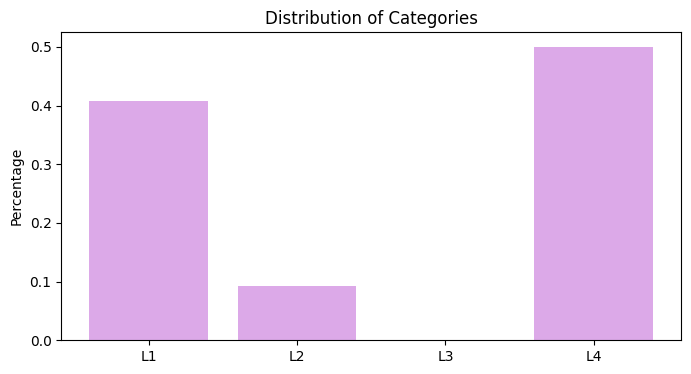

In [43]:
categories = ['L1', 'L2', 'L3', 'L4']
percentages = [np.sum(l1s)/all_layer_weights.shape[0], np.sum(l2s)/all_layer_weights.shape[0], np.sum(l3s)/all_layer_weights.shape[0], np.sum(l4s)/all_layer_weights.shape[0]]

plt.figure(figsize=(8, 4))
plt.bar(categories, percentages, alpha=0.5, color='mediumorchid')
plt.ylabel('Percentage')
plt.title('Distribution of Categories')
plt.show()

In [45]:
## Need to cut this up so if it is within the range for a certain layer then it gets processed differently, also I should start with just the top 1 i think or average only within a layer
all_feature_maps = []
l1_idx = []
l2_idx = []
l3_idx = []
l4_idx = []
for neuron_idx in range(all_layer_weights.shape[0]):
    top_positive_indices = np.argsort(all_layer_weights[neuron_idx, :])[-1:]
    # print(neuron_idx)
    l1_featmap = []
    l2_featmap = []
    l3_featmap = []
    l4_featmap = []
    # go through each strong weight and categorize by layer
    for idx in top_positive_indices:

        # if the index is within a given layer then it will find what the index would be in terms of num of filters per layer, then
        if idx < l1_bound:
            X_idx = int(idx/(feature_map1[0].shape[1]**2))
            l1_idx.append(X_idx)
            l1_featmap.append(all_layers[76, :l1_bound].reshape(feature_map1[0].shape[0], feature_map1[0].shape[1], feature_map1[0].shape[2])[X_idx])
            # print(neuron_idx, 'l1')
        elif l1_bound < idx < l2_bound:
            X_idx = int((idx-l1_bound)/(feature_map2[0].shape[1]**2))
            l2_idx.append(X_idx)
            l2_featmap.append(all_layers[76, l1_bound: l2_bound].reshape(feature_map2[0].shape[0], feature_map2[0].shape[1], feature_map2[0].shape[2])[X_idx])
            # print(neuron_idx, 'l2')
        elif l2_bound < idx < l3_bound:
            X_idx = int((idx-l2_bound)/(feature_map3[0].shape[1]**2))
            l3_idx.append(X_idx)
            l3_featmap.append(all_layers[76, l2_bound: l3_bound].reshape(feature_map3[0].shape[0], feature_map3[0].shape[1], feature_map3[0].shape[2])[X_idx])
            # print(neuron_idx, 'l3')
        elif l3_bound < idx < l4_bound:
            X_idx = int((idx-l3_bound)/(feature_map4[0].shape[1]**2))
            l4_idx.append(X_idx)
            l4_featmap.append(all_layers[76, l3_bound: l4_bound].reshape(feature_map4[0].shape[0], feature_map4[0].shape[1], feature_map4[0].shape[2])[X_idx])
            # print(neuron_idx, 'l4')

    # print(len(l1_featmap))
    # print(len(l2_featmap))
    # print(len(l3_featmap))
    # print(len(l4_featmap))

    if len(l1_featmap)>1:
        all_feature_maps.append(np.array(l1_featmap).mean(axis=0))
    elif 0<len(l1_featmap)<=1:
        all_feature_maps.append(np.array(l1_featmap)[0])
    if len(l2_featmap)>1:
        all_feature_maps.append(np.array(l2_featmap).mean(axis=0))
    elif 0<len(l2_featmap)<=1:
        all_feature_maps.append(np.array(l2_featmap)[0])
    if len(l3_featmap)>1:
        all_feature_maps.append(np.array(l3_featmap).mean(axis=0))
    elif 0<len(l3_featmap)<=1:
        all_feature_maps.append(np.array(l3_featmap)[0])
    if len(l4_featmap)>1:
        all_feature_maps.append(np.array(l4_featmap).mean(axis=0))
    elif 0<len(l4_featmap)<=1:
        all_feature_maps.append(np.array(l4_featmap)[0])
    # all_feature_maps.append(feature_map_patches)

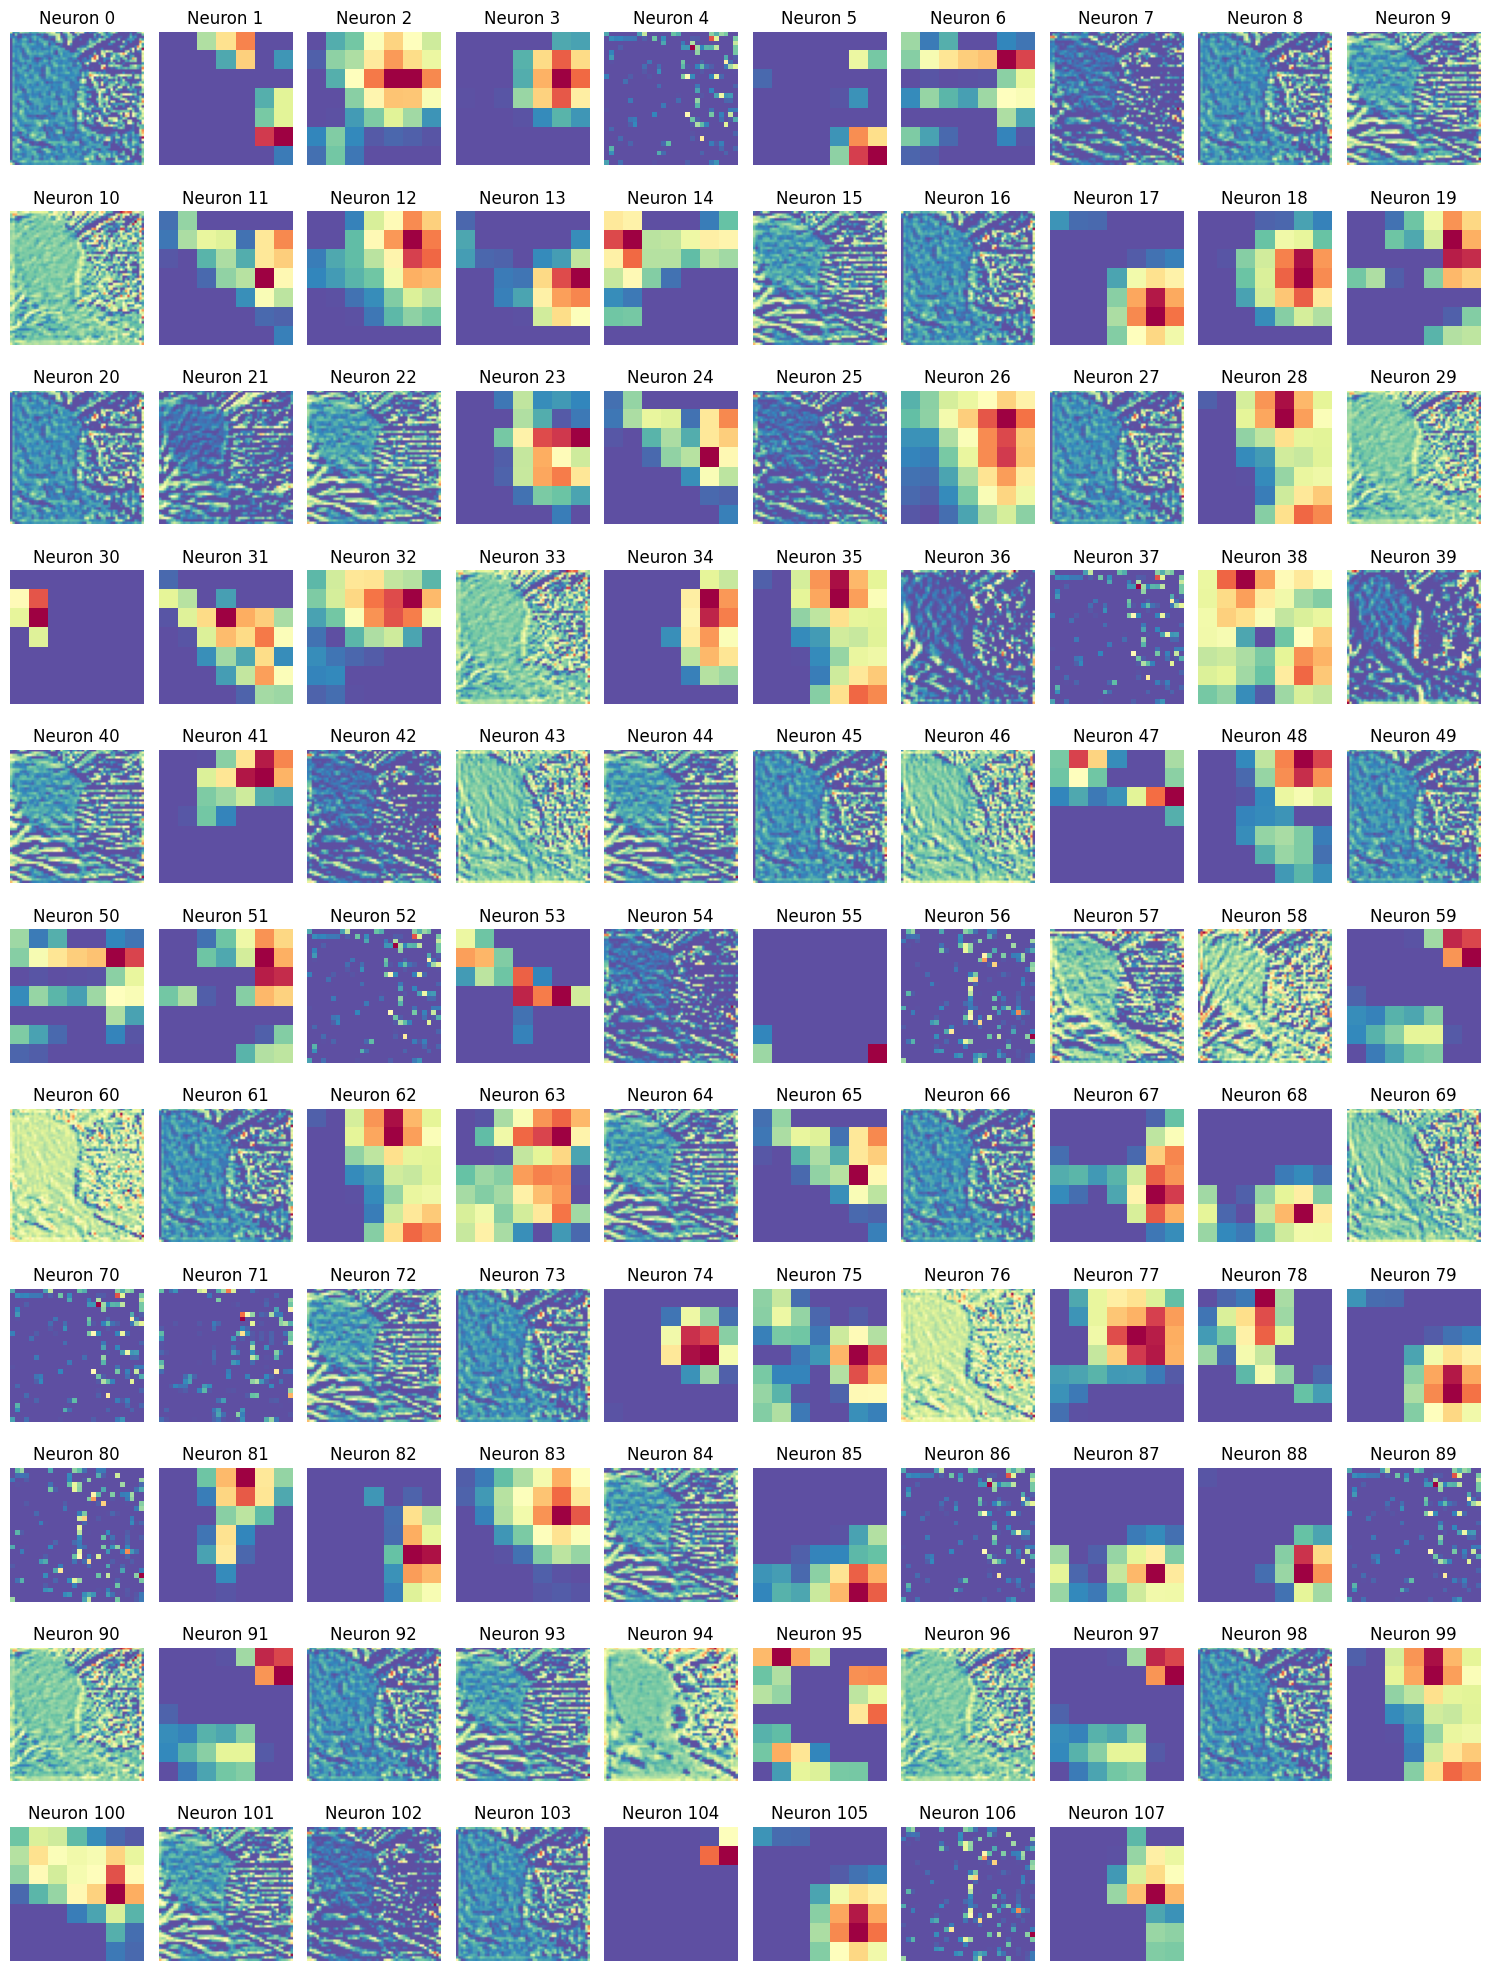

In [46]:
# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=11, ncols=10, figsize=(15, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop over each subplot and each image
for idx, ax in enumerate(axes):
    if idx < len(all_feature_maps):
        ax.imshow(all_feature_maps[idx], cmap='Spectral_r')  # Display the image
        ax.set_title(f"Neuron {idx}")
        ax.axis('off')  # Optionally turn off the axes
    else:
        ax.axis('off')  # Turn off empty subplots if any


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


## Create Movies

In [ ]:
## Need to cut this up so if it is within the range for a certain layer then it gets processed differently, also I should start with just the top 1 i think or average only within a layer
all_feature_maps = []

for neuron_idx in range(all_layer_weights.shape[0]):
    top_positive_indices = np.argsort(all_layer_weights[neuron_idx, :])[-1:]


    # Extract the embeddings for all of the images in the movie
    multi_feature_map = []
    for frame in range(all_layers.shape[0]):
        l1_featmap = []
        l2_featmap = []
        l3_featmap = []
        l4_featmap = []

        # go through each strong weight and categorize by layer
        for idx in top_positive_indices:

            # if the index is within a given layer then it will find what the index would be in terms of num of filters per layer, then
            if idx < l1_bound:
                X_idx = int(idx/(feature_map1[0].shape[1]**2))
                l1_featmap.append(all_layers[frame, :l1_bound].reshape(feature_map1[0].shape[0], feature_map1[0].shape[1], feature_map1[0].shape[2])[X_idx])

            elif l1_bound < idx < l2_bound:
                X_idx = int((idx-l1_bound)/(feature_map2[0].shape[1]**2))
                l2_featmap.append(all_layers[frame, l1_bound: l2_bound].reshape(feature_map2[0].shape[0], feature_map2[0].shape[1], feature_map2[0].shape[2])[X_idx])

            elif l2_bound < idx < l3_bound:
                X_idx = int((idx-l2_bound)/(feature_map3[0].shape[1]**2))
                l3_featmap.append(all_layers[frame, l2_bound: l3_bound].reshape(feature_map3[0].shape[0], feature_map3[0].shape[1], feature_map3[0].shape[2])[X_idx])

            elif l3_bound < idx < l4_bound:
                X_idx = int((idx-l3_bound)/(feature_map4[0].shape[1]**2))
                l4_featmap.append(all_layers[frame, l3_bound: l4_bound].reshape(feature_map4[0].shape[0], feature_map4[0].shape[1], feature_map4[0].shape[2])[X_idx])

        if len(l1_featmap)>1:
            multi_feature_map.append(np.array(l1_featmap).mean(axis=0))
        elif 0<len(l1_featmap)<=1:
            multi_feature_map.append(np.array(l1_featmap)[0])
        if len(l2_featmap)>1:
            multi_feature_map.append(np.array(l2_featmap).mean(axis=0))
        elif 0<len(l2_featmap)<=1:
            multi_feature_map.append(np.array(l2_featmap)[0])
        if len(l3_featmap)>1:
            multi_feature_map.append(np.array(l3_featmap).mean(axis=0))
        elif 0<len(l3_featmap)<=1:
            multi_feature_map.append(np.array(l3_featmap)[0])
        if len(l4_featmap)>1:
            multi_feature_map.append(np.array(l4_featmap).mean(axis=0))
        elif 0<len(l4_featmap)<=1:
            multi_feature_map.append(np.array(l4_featmap)[0])
    all_feature_maps.append(np.array(multi_feature_map))

In [ ]:
def create_movie_from_arrays(feature_maps, output_filename, fps=30):
    if feature_maps.shape[1] == 7:
        upscale_factor=40
    elif feature_maps.shape[1] == 28:
        upscale_factor=10
    elif feature_maps.shape[1] == 56:
        upscale_factor=5

    # Get the dimensions of the arrays
    height, width = feature_maps[0].shape

    # Create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (width * upscale_factor, height * upscale_factor))

    # Create colormap object
    cmap = plt.get_cmap('Spectral_r')

    for arr in tqdm(feature_maps, desc="Processing frames"):
        # Normalize the array to 0-1 range
        normalized = (arr - arr.min()) / (arr.max() - arr.min())

        # Apply colormap
        colored = (cmap(normalized) * 255).astype(np.uint8)

        # OpenCV uses BGR, so we need to convert from RGB
        colored_bgr = cv2.cvtColor(colored, cv2.COLOR_RGB2BGR)

        upscaled = cv2.resize(colored_bgr, (width * upscale_factor, height * upscale_factor), interpolation=cv2.INTER_NEAREST)

        out.write(upscaled)

    # Release the VideoWriter
    out.release()

In [ ]:
# for neuron in range(all_layer_weights.shape[0]):
#   create_movie_from_arrays(all_feature_maps[neuron], datadir/f'all_output_movie_{neuron}.mp4', fps=30)

### Combined Movie and Neuron

In [ ]:
image_path = []
for i in np.arange(74,599):
  image_path.append(str(datadir/f'touch_of_evil/frame_{i}.png'))

### Functions

In [ ]:
def create_combined_movie_single(activations, path_to_images, output_filename, fps=30):
    if activations.shape[1] == 7:
        upscale_factor=40
    elif activations.shape[1] == 28:
        upscale_factor=10
    elif activations.shape[1] == 56:
        upscale_factor=5

    # Get the dimensions of the arrays
    height, width = activations[0].shape

    # Get dimensions of the original frames
    with Image.open(path_to_images[0]) as img:
        orig_width, orig_height = img.size

    # Calculate dimensions for the combined frame
    combined_width = orig_width + (width * upscale_factor)
    combined_height = max(orig_height, height * upscale_factor)

    # Create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (combined_width, combined_height))

    # Create colormap object
    cmap = plt.get_cmap('Spectral_r')

    for arr, orig_frame_path in tqdm(zip(activations, path_to_images), desc="Processing frames", total=len(activations)):
        # Process the array
        normalized = (arr - arr.min()) / (arr.max() - arr.min())
        colored = (cmap(normalized) * 255).astype(np.uint8)
        colored_bgr = cv2.cvtColor(colored, cv2.COLOR_RGB2BGR)
        upscaled = cv2.resize(colored_bgr, (width * upscale_factor, height * upscale_factor), interpolation=cv2.INTER_NEAREST)

        # Load and resize the original frame
        with Image.open(orig_frame_path) as img:
            orig_frame = np.array(img)
        orig_frame = cv2.cvtColor(orig_frame, cv2.COLOR_RGB2BGR)
        orig_frame = cv2.resize(orig_frame, (orig_width, orig_height))

        # Create a blank canvas for the combined frame
        combined_frame = np.zeros((combined_height, combined_width, 3), dtype=np.uint8)

        # Place the original frame on the left and upscaled array on the right
        combined_frame[:orig_height, :orig_width] = orig_frame
        combined_frame[:height * upscale_factor, orig_width:] = upscaled

        # Write the combined frame
        out.write(combined_frame)

    # Release the VideoWriter
    out.release()

def create_combined_movie_multi(array_list1, array_list2, original_frames, output_filename, fps=30, gap=10):
    if array_list1.shape[1] == 7:
        upscale_factor=40
    elif array_list1.shape[1] == 28:
        upscale_factor=10
    elif array_list1.shape[1] == 56:
        upscale_factor=5

    if array_list2.shape[1] == 7:
        upscale_factor=40
    elif array_list2.shape[1] == 28:
        upscale_factor=10
    elif array_list2.shape[1] == 56:
        upscale_factor=5

    # Get the dimensions of the arrays
    height, width = array_list1[0].shape

    # Get dimensions of the original frames
    with Image.open(original_frames[0]) as img:
        orig_width, orig_height = img.size

    # Calculate dimensions for the combined frame
    viz_width = width * upscale_factor
    viz_height = height * upscale_factor
    combined_width = orig_width + viz_width + gap
    combined_height = max(orig_height, 2 * viz_height + 2 * gap)

    # Create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (combined_width, combined_height))

    # Create colormap object
    cmap = plt.get_cmap('Spectral_r')

    def process_array(arr):
        normalized = (arr - arr.min()) / (arr.max() - arr.min())
        colored = (cmap(normalized) * 255).astype(np.uint8)
        colored_bgr = cv2.cvtColor(colored, cv2.COLOR_RGB2BGR)
        return cv2.resize(colored_bgr, (viz_width, viz_height), interpolation=cv2.INTER_NEAREST)

    for arr1, arr2, orig_frame_path in tqdm(zip(array_list1, array_list2, original_frames), desc="Processing frames", total=len(array_list1)):
        # Process the arrays
        upscaled1 = process_array(arr1)
        upscaled2 = process_array(arr2)

        # Load and resize the original frame
        with Image.open(orig_frame_path) as img:
            orig_frame = np.array(img)
        orig_frame = cv2.cvtColor(orig_frame, cv2.COLOR_RGB2BGR)
        orig_frame = cv2.resize(orig_frame, (orig_width, orig_height))

        # Create a blank canvas for the combined frame
        combined_frame = np.zeros((combined_height, combined_width, 3), dtype=np.uint8)

        # Place the original frame on the left
        combined_frame[:orig_height, :orig_width] = orig_frame

        # Place the upscaled arrays stacked vertically on the right
        combined_frame[5:viz_height+5, orig_width + gap:] = upscaled1
        combined_frame[viz_height + gap + 5:2*viz_height + gap+5, orig_width + gap:] = upscaled2

        # Write the combined frame
        out.write(combined_frame)

    # Release the VideoWriter
    out.release()

In [ ]:
def create_combined_movie_multi(array_list1, array_list2, original_frames, output_filename, fps=30, gap=10):
    # Function to determine upscale factor
    def get_upscale_factor(array_shape):
        if array_shape[0] == 7:
            return 40
        elif array_shape[0] == 28:
            return 10
        elif array_shape[0] == 56:
            return 5
        else:
            return max(1, 280 // array_shape[0])  # Default scaling

    # Get upscale factors for both arrays
    upscale_factor1 = get_upscale_factor(array_list1[0].shape)
    upscale_factor2 = get_upscale_factor(array_list2[0].shape)

    # Calculate visualized dimensions
    viz_width1 = array_list1[0].shape[1] * upscale_factor1
    viz_height1 = array_list1[0].shape[0] * upscale_factor1
    viz_width2 = array_list2[0].shape[1] * upscale_factor2
    viz_height2 = array_list2[0].shape[0] * upscale_factor2

    # Use the larger dimensions for both visualizations
    viz_width = max(viz_width1, viz_width2)
    viz_height = max(viz_height1, viz_height2)

    # Get dimensions of the original frames
    with Image.open(original_frames[0]) as img:
        orig_width, orig_height = img.size

    # Calculate dimensions for the combined frame
    combined_width = orig_width + viz_width + gap
    combined_height = max(orig_height, 2 * viz_height + 2 * gap)

    # Create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (combined_width, combined_height))

    # Create colormap object
    cmap = plt.get_cmap('Spectral_r')

    def process_array(arr, target_width, target_height):
        normalized = (arr - arr.min()) / (arr.max() - arr.min())
        colored = (cmap(normalized) * 255).astype(np.uint8)
        colored_bgr = cv2.cvtColor(colored, cv2.COLOR_RGB2BGR)
        return cv2.resize(colored_bgr, (target_width, target_height), interpolation=cv2.INTER_NEAREST)

    for arr1, arr2, orig_frame_path in tqdm(zip(array_list1, array_list2, original_frames), desc="Processing frames", total=len(array_list1)):
        # Process the arrays
        upscaled1 = process_array(arr1, viz_width, viz_height)
        upscaled2 = process_array(arr2, viz_width, viz_height)

        # Load and resize the original frame
        with Image.open(orig_frame_path) as img:
            orig_frame = np.array(img)
        orig_frame = cv2.cvtColor(orig_frame, cv2.COLOR_RGB2BGR)
        orig_frame = cv2.resize(orig_frame, (orig_width, orig_height))

        # Create a blank canvas for the combined frame
        combined_frame = np.zeros((combined_height, combined_width, 3), dtype=np.uint8)

        # Place the original frame on the left
        combined_frame[:orig_height, :orig_width] = orig_frame

        # Place the upscaled arrays stacked vertically on the right
        combined_frame[5:viz_height+5, orig_width + gap:] = upscaled1
        combined_frame[viz_height + gap + 5:2*viz_height + gap+5, orig_width + gap:] = upscaled2

        # Write the combined frame
        out.write(combined_frame)

    # Release the VideoWriter
    out.release()

### Multi-neuron movie

In [ ]:
# create_combined_movie_single(all_feature_maps[0], image_path, datadir/'combined_output_movie_ridge.mp4', fps=30)

# create_combined_movie_multi(all_feature_maps[0], all_feature_maps[3], image_path, datadir/'combined_output_movie_2n_gap_ridge.mp4', fps=30)

# Basic Level - Finding influence of neurons in l1 on l4

In [48]:
def compute_feature_influence_resnet(model, pixel_values):
    model.eval()

    # Forward pass
    outputs = model(pixel_values, output_hidden_states=True)
    hidden_states = outputs.hidden_states

    first_layer = hidden_states[1]  # Output of conv1
    last_layer = hidden_states[-1]  # Last layer

    first_layer.retain_grad()

    influence = []
    for i in range(last_layer.size(1)):  # For each channel in the last layer
        model.zero_grad()
        if first_layer.grad is not None:
            first_layer.grad.zero_()

        last_layer[0, i].mean().backward(retain_graph=True)

        gradient = first_layer.grad.data
        influence.append(gradient.abs().mean(dim=[0, 2, 3]).cpu().numpy())

    influence = np.array(influence)  # Shape: [last_layer_channels, 64]

    return influence

In [49]:
def compute_average_influence_resnet(model, feature_extractor, image_paths):
    model.eval()

    total_influence = None

    for image_path in tqdm(image_paths):
        image = Image.open(image_path).convert('RGB')
        inputs = feature_extractor(images=image, return_tensors="pt")
        pixel_values = inputs["pixel_values"].to(model.device)

        influence = compute_feature_influence_resnet(model, pixel_values)

        if total_influence is None:
            total_influence = influence
        else:
            total_influence += influence

    average_influence = total_influence / len(image_paths)

    return average_influence

In [ ]:
# Load pre-trained model and feature extractor
model_name = "microsoft/resnet-18"
model = AutoModel.from_pretrained(model_name)
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

image_paths = []
for i in np.arange(74,599):
  image_paths.append(str(datadir/f'touch_of_evil/frame_{i}.png'))

/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [ ]:
# Compute average influence
average_influence = compute_average_influence_resnet(model, feature_extractor, image_paths)

100%|██████████| 525/525 [17:33<00:00,  2.01s/it]


In [50]:
# Saved previously
average_influence = np.load(datadir/'average_influence.npy', allow_pickle=True)
l4_idx = np.load(datadir/'l4_idx.npy', allow_pickle=True)
l1_idx = np.load(datadir/'l1_idx.npy', allow_pickle=True)

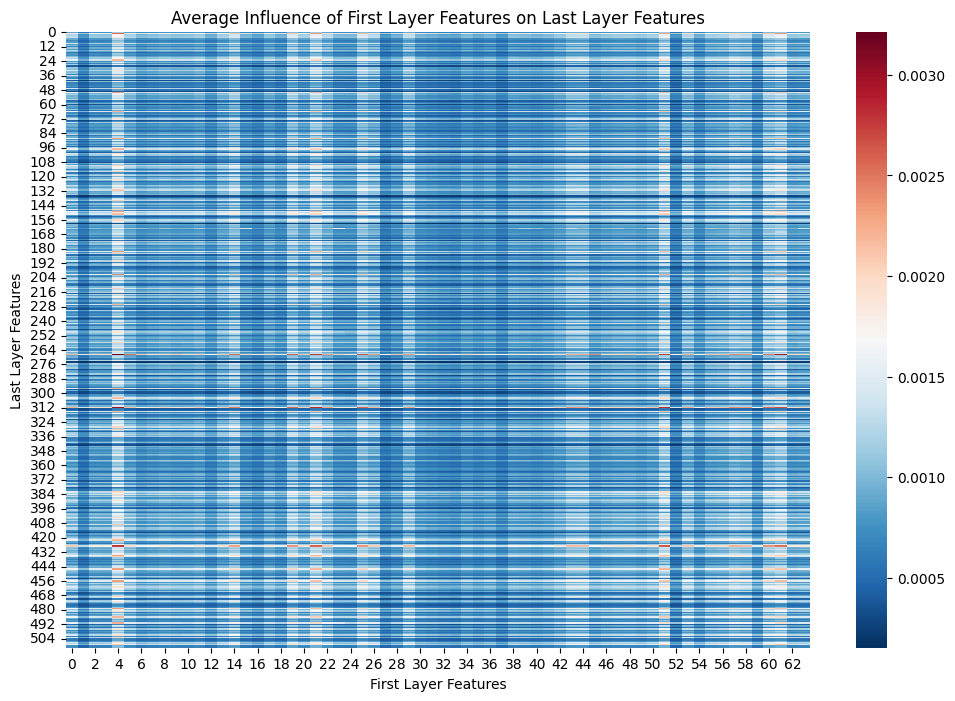

In [52]:
 # Visualize the result
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(average_influence, cmap='RdBu_r')
plt.title('Average Influence of First Layer Features on Last Layer Features')
plt.xlabel('First Layer Features')
plt.ylabel('Last Layer Features')
plt.show()

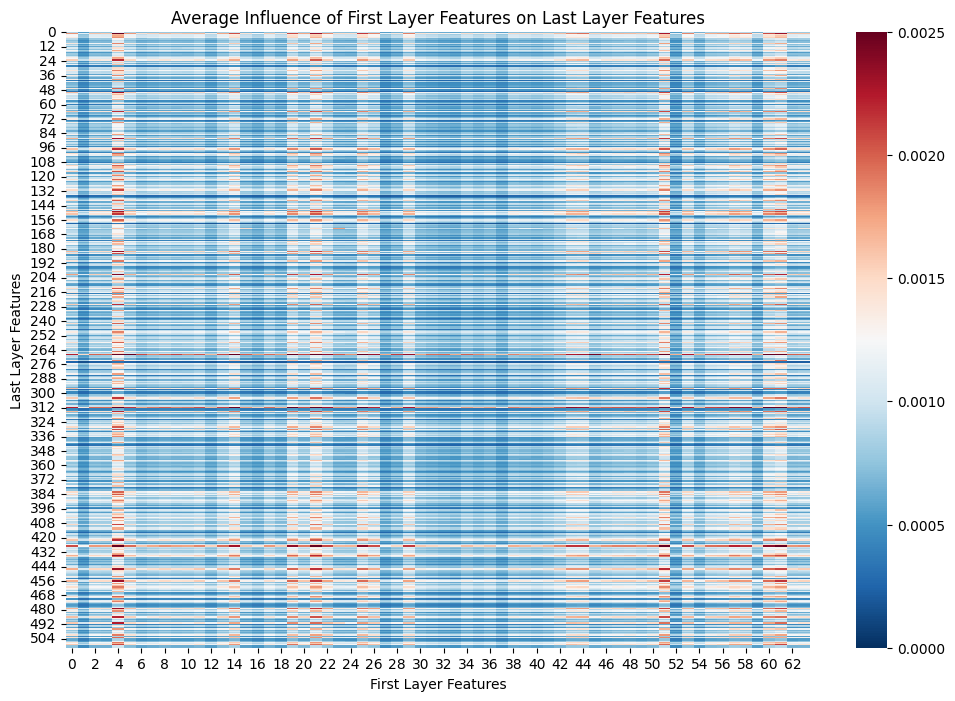

In [53]:
plt.figure(figsize=(12, 8))
sns.heatmap(average_influence, cmap='RdBu_r', vmin=0, vmax=0.0025)
plt.title('Average Influence of First Layer Features on Last Layer Features')
plt.xlabel('First Layer Features')
plt.ylabel('Last Layer Features')
# plt.savefig(datadir/'influence_allcells_first.png')
plt.show()

# SAE Analysis

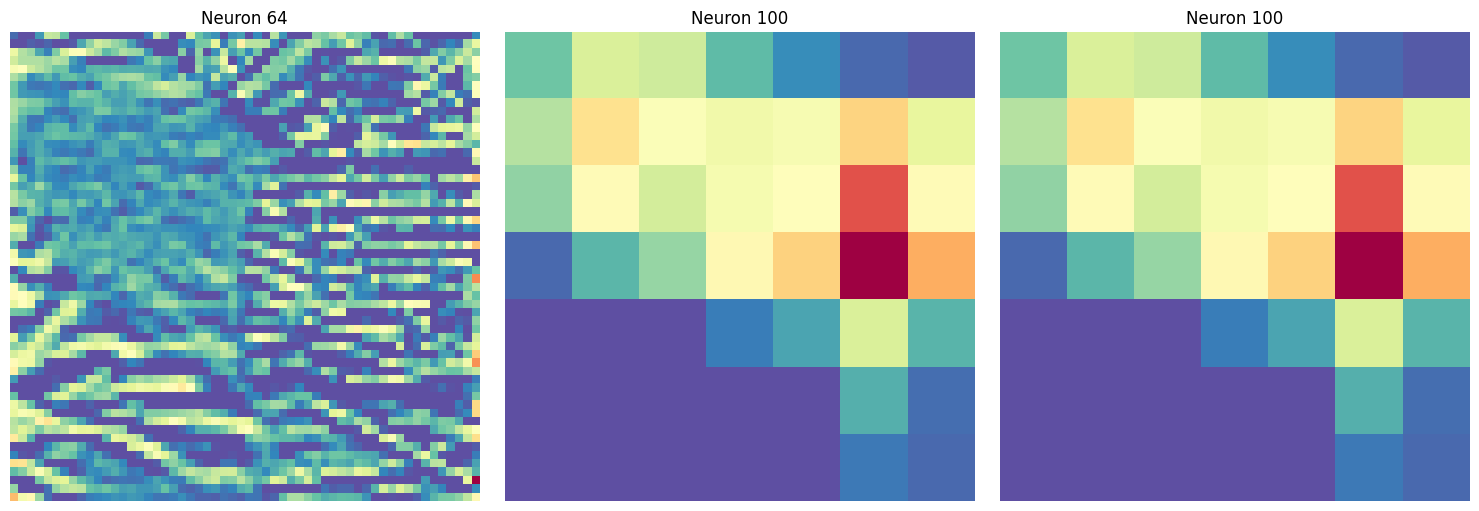

In [ ]:
sae_high_neurons = [64, 100, 100]

# Determine the number of neurons to plot
num_neurons = len(sae_high_neurons)

# Create a figure with subplots in a single row
fig, axes = plt.subplots(1, num_neurons, figsize=(5*num_neurons, 5))

# Ensure axes is always a list, even if there's only one subplot
if num_neurons == 1:
    axes = [axes]

for idx, ax in zip(sae_high_neurons, axes):
    ax.imshow(all_feature_maps[idx], cmap='Spectral_r')
    ax.set_title(f"Neuron {idx}")
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
# plt.savefig(datadir/'SAE_unit2_neurons.png')

# Show the plot
plt.show()

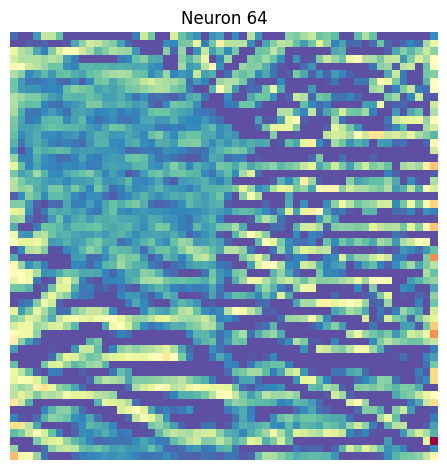

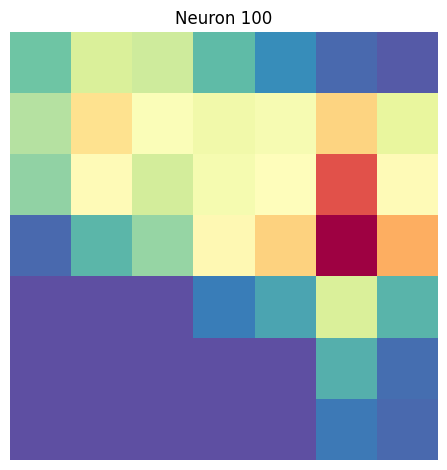

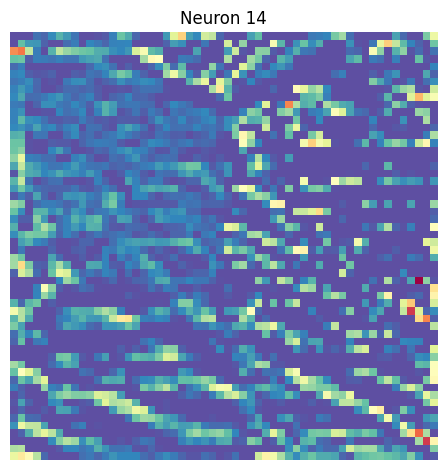

In [ ]:
for idx in sae_high_neurons:
    plt.imshow(all_feature_maps[idx], cmap='Spectral_r')  # Display the image
    plt.title(f"Neuron {idx}")
    plt.axis('off')  # Optionally turn off the axes


    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()


In [55]:
all_sae_top = np.unique([64, 96, 102, 76, 99, 70, 49, 103, 54, 36])

In [56]:
all_sae_top2 = np.unique([100, 102, 100, 44, 40, 33, 94, 47, 58, 49])

In [57]:
## Need to cut this up so if it is within the range for a certain layer then it gets processed differently, also I should start with just the top 1 i think or average only within a layer
all_feature_maps_ = []
l1_idx_ = []
l2_idx_ = []
l3_idx_ = []
l4_idx_ = []

l1_neurons = []
l2_neurons = []
l3_neurons = []
l4_neurons = []

for neuron_idx in all_sae_top2:
    top_positive_indices = np.argsort(all_layer_weights[neuron_idx, :])[-1:]
    # print(neuron_idx)
    l1_featmap = []
    l2_featmap = []
    l3_featmap = []
    l4_featmap = []
    # go through each strong weight and categorize by layer
    for idx in top_positive_indices:

        # if the index is within a given layer then it will find what the index would be in terms of num of filters per layer, then
        if idx < l1_bound:
            X_idx = int(idx/(feature_map1[0].shape[1]**2))
            l1_neurons.append(neuron_idx)
            l1_idx_.append(X_idx)
            l1_featmap.append(all_layers[76, :l1_bound].reshape(feature_map1[0].shape[0], feature_map1[0].shape[1], feature_map1[0].shape[2])[X_idx])
            # print(neuron_idx, 'l1')
        elif l1_bound < idx < l2_bound:
            X_idx = int((idx-l1_bound)/(feature_map2[0].shape[1]**2))
            l2_neurons.append(neuron_idx)
            l2_idx_.append(X_idx)
            l2_featmap.append(all_layers[76, l1_bound: l2_bound].reshape(feature_map2[0].shape[0], feature_map2[0].shape[1], feature_map2[0].shape[2])[X_idx])
            # print(neuron_idx, 'l2')
        elif l2_bound < idx < l3_bound:
            X_idx = int((idx-l2_bound)/(feature_map3[0].shape[1]**2))
            l3_neurons.append(neuron_idx)
            l3_idx_.append(X_idx)
            l3_featmap.append(all_layers[76, l2_bound: l3_bound].reshape(feature_map3[0].shape[0], feature_map3[0].shape[1], feature_map3[0].shape[2])[X_idx])
            # print(neuron_idx, 'l3')
        elif l3_bound < idx < l4_bound:
            X_idx = int((idx-l3_bound)/(feature_map4[0].shape[1]**2))
            l4_neurons.append(neuron_idx)
            l4_idx_.append(X_idx)
            l4_featmap.append(all_layers[76, l3_bound: l4_bound].reshape(feature_map4[0].shape[0], feature_map4[0].shape[1], feature_map4[0].shape[2])[X_idx])
            # print(neuron_idx, 'l4')

    # print(len(l1_featmap))
    # print(len(l2_featmap))
    # print(len(l3_featmap))
    # print(len(l4_featmap))

    if len(l1_featmap)>1:
        all_feature_maps_.append(np.array(l1_featmap).mean(axis=0))
    elif 0<len(l1_featmap)<=1:
        all_feature_maps_.append(np.array(l1_featmap)[0])
    if len(l2_featmap)>1:
        all_feature_maps_.append(np.array(l2_featmap).mean(axis=0))
    elif 0<len(l2_featmap)<=1:
        all_feature_maps.append(np.array(l2_featmap)[0])
    if len(l3_featmap)>1:
        all_feature_maps_.append(np.array(l3_featmap).mean(axis=0))
    elif 0<len(l3_featmap)<=1:
        all_feature_maps_.append(np.array(l3_featmap)[0])
    if len(l4_featmap)>1:
        all_feature_maps_.append(np.array(l4_featmap).mean(axis=0))
    elif 0<len(l4_featmap)<=1:
        all_feature_maps_.append(np.array(l4_featmap)[0])
    # all_feature_maps_.append(feature_map_patches)

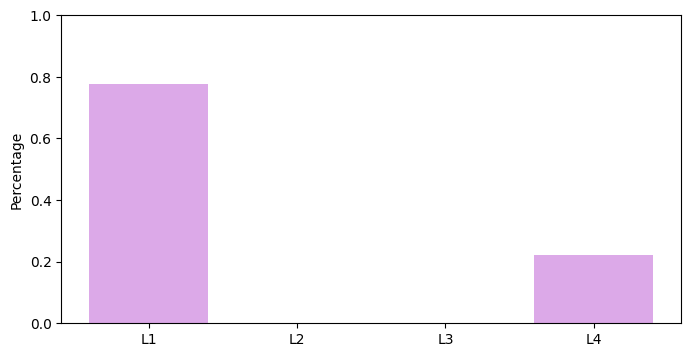

In [59]:
categories = ['L1', 'L2', 'L3', 'L4']
percentages = [len(l1_neurons)/len(all_sae_top2), len(l2_neurons)/len(all_sae_top2), len(l3_neurons)/len(all_sae_top2), len(l4_neurons)/len(all_sae_top2)]

plt.figure(figsize=(8, 4))
plt.bar(categories, percentages, alpha=0.5, color='mediumorchid')
plt.ylim(0, 1)
plt.ylabel('Percentage')
# plt.title('Distribution of Categories')
# plt.savefig(datadir/'top10SAE2_dist.png')
plt.show()

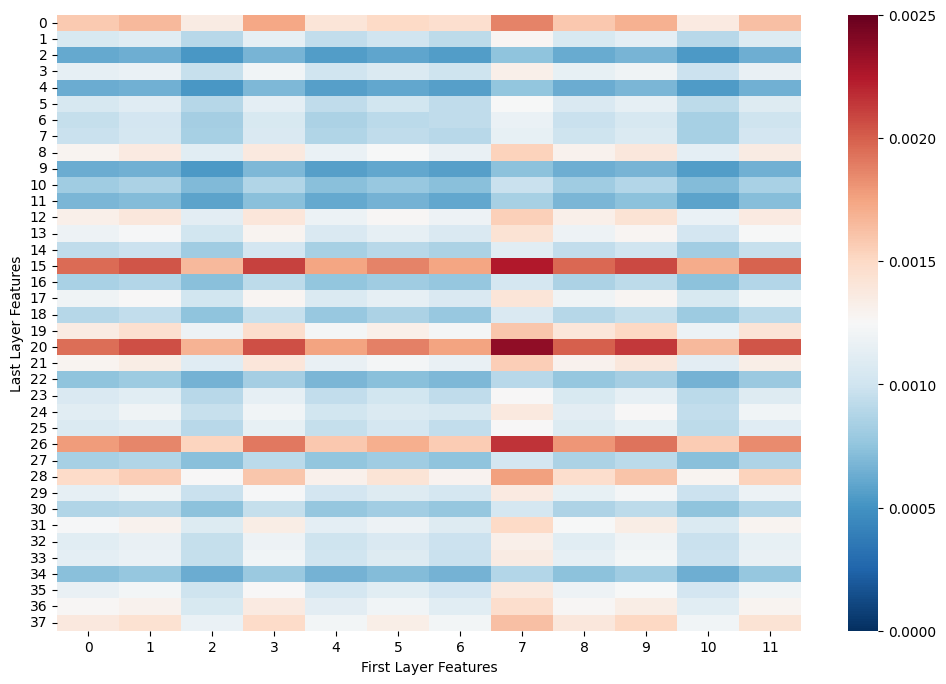

In [64]:
plt.figure(figsize=(12, 8))
sns.heatmap(average_influence[np.unique(l4_idx)][:,np.unique(l1_idx)], cmap='RdBu_r', vmin=0, vmax=0.0025)
# plt.title('Average Influence of First Layer Features on Last Layer Features')
plt.xlabel('First Layer Features')
plt.ylabel('Last Layer Features')
# plt.savefig(datadir/'allSAE_feature_influence2_top10.png')
plt.show()

# Movies for SAE or High Influence Neurons

In [ ]:
X_idx = l4_idx[10]
ex_map = all_layers[5, l3_bound:l4_bound].reshape(feature_map4[0].shape[0], feature_map4[0].shape[1], feature_map4[0].shape[2])[X_idx]

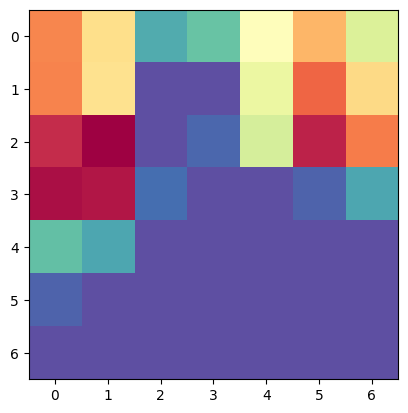

In [ ]:
plt.imshow(ex_map, cmap='Spectral_r')

In [ ]:
multi_feature_map_l1 = []
# X_idx = l1_idx_[7]
idx = np.argsort(all_layer_weights[64, :])[-1:]
X_idx = int(idx/(feature_map1[0].shape[1]**2))
for frame in range(all_layers.shape[0]):
    multi_feature_map_l1.append(all_layers[frame, :l1_bound].reshape(feature_map1[0].shape[0], feature_map1[0].shape[1], feature_map1[0].shape[2])[X_idx])

<ipython-input-91-1abea370e7ef>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_idx = int(idx/(feature_map1[0].shape[1]**2))


In [ ]:
create_movie_from_arrays(np.array(multi_feature_map_l1), datadir/f'all_output_movie_l1.mp4', fps=30)

Processing frames: 100%|██████████| 525/525 [00:00<00:00, 631.46it/s]


In [ ]:
multi_feature_map_l4 = []
# X_idx = l4_idx_[10]
idx = np.argsort(all_layer_weights[100, :])[-1:]
X_idx = int(idx/(feature_map1[0].shape[1]**2))
for frame in range(all_layers.shape[0]):
    multi_feature_map_l4.append(all_layers[frame, l3_bound:l4_bound].reshape(feature_map4[0].shape[0], feature_map4[0].shape[1], feature_map4[0].shape[2])[X_idx])

<ipython-input-92-3c2f69ac0f68>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_idx = int(idx/(feature_map1[0].shape[1]**2))


In [ ]:
create_movie_from_arrays(np.array(multi_feature_map_l4), datadir/f'all_output_movie_l4.mp4', fps=30)

Processing frames:   0%|          | 0/525 [00:00<?, ?it/s]<ipython-input-36-8a06a114aee5>:21: RuntimeWarning: invalid value encountered in divide
  normalized = (arr - arr.min()) / (arr.max() - arr.min())
Processing frames: 100%|██████████| 525/525 [00:00<00:00, 1122.16it/s]


In [ ]:
create_combined_movie_multi(np.array(multi_feature_map_l1), np.array(multi_feature_map_l4), image_path, datadir/'combined_output_movie_sae.mp4', fps=30)

Processing frames: 100%|██████████| 525/525 [00:12<00:00, 40.75it/s]


In [ ]:
create_combined_movie_multi(np.array(multi_feature_map_l1), np.array(multi_feature_map_l4), image_path, datadir/'combined_output_movie_sae_unit1.mp4', fps=30)

Processing frames: 100%|██████████| 525/525 [00:13<00:00, 39.67it/s]


## Generate random indices to test if the mean influence is greater for the selected neurons compared to randomly selected

In [ ]:
def generate_random_indices(num_indices, max_index, seed=None):
    """
    Generate a specified number of unique random indices.

    Parameters:
    num_indices (int): The number of random indices to generate.
    max_index (int): The maximum index value (exclusive).
    seed (int, optional): Seed for the random number generator for reproducibility.

    Returns:
    numpy.ndarray: An array of unique random indices.
    """
    if seed is not None:
        np.random.seed(seed)

    if num_indices > max_index:
        raise ValueError("num_indices cannot be greater than max_index")

    return np.random.choice(max_index, size=num_indices, replace=False)

# Example usage:
# Let's say you want 10 random indices from a range of 0 to 99
num_random_indices = 10
max_index_value = 100  # This will generate indices from 0 to 99

random_indices = generate_random_indices(num_random_indices, max_index_value)
print(f"Generated {num_random_indices} random indices: {random_indices}")

# If you want reproducible results, use a seed
random_indices_with_seed = generate_random_indices(num_random_indices, max_index_value, seed=42)
print(f"Generated {num_random_indices} random indices with seed: {random_indices_with_seed}")

Generated 10 random indices: [91 70 12 26 54 61 62 50 82 43]
Generated 10 random indices with seed: [83 53 70 45 44 39 22 80 10  0]


In [ ]:
avg_inf = []
for boot in range(1000):

    # For layer1 conv1 (assuming it has 64 filters and is the first layer in your influence matrix)
    layer1_conv1_indices = generate_random_indices(11, 64)

    # For layer4 conv1 (assuming it has 512 filters and starts at index 1000 in your influence matrix)
    layer4_conv1_indices = generate_random_indices(37, 512)

    print("Random indices for layer1 conv1:", layer1_conv1_indices)
    print("Random indices for layer4 conv1:", layer4_conv1_indices)

    # plt.figure(figsize=(12, 8))
    # sns.heatmap(average_influence[np.unique(layer4_conv1_indices)][:,np.unique(layer1_conv1_indices)], cmap='RdBu_r', vmin=0, vmax=0.0025)
    avg_inf.append(average_influence[np.unique(layer4_conv1_indices)][:,np.unique(layer1_conv1_indices)].mean())
    # plt.title('Average Influence of First Layer Features on Last Layer Features')
    # plt.xlabel('First Layer Features')
    # plt.ylabel('Last Layer Features')
    # plt.savefig(datadir/f'feature_influence_rand{boot}.png')


Random indices for layer1 conv1: [63 45 48 53 17 29  1 49  5 37 19]
Random indices for layer4 conv1: [ 86 352 419 211  87 138  31  40 487 235  10 170 264 240  14 321 256 422
 275  90 511 215 161 289 365  69 110 423 156  65 259  55 320 278 414 192
   2]
Random indices for layer1 conv1: [ 3 33 45 44 39 60 32 56 49 34  6]
Random indices for layer4 conv1: [390 247 260 155  57 413 313  58 188 148 173 395  15 190 379  70 241 114
 446  86 501 297 277 332 210 140 418 468 375 401 352 180  79 415 240 422
  23]
Random indices for layer1 conv1: [ 8 60 36 58 16 11  5 20 62 47 10]
Random indices for layer4 conv1: [480 191  42 366 368 349 436 359 204 305 105 327 478 482 241 419  65 251
 143 149 117 242 210 185 166   7 240 179 154  48  17 351  23 410 483 422
 270]
Random indices for layer1 conv1: [63 39  2  4 33 22 36 25  6  5 34]
Random indices for layer4 conv1: [247 139 111 345 471 248 291  61 274  15 398 243 147 371 336 266 337  78
 509  28 332 321  29 362 288  16  57  30 276 259  60 474 280 445 35

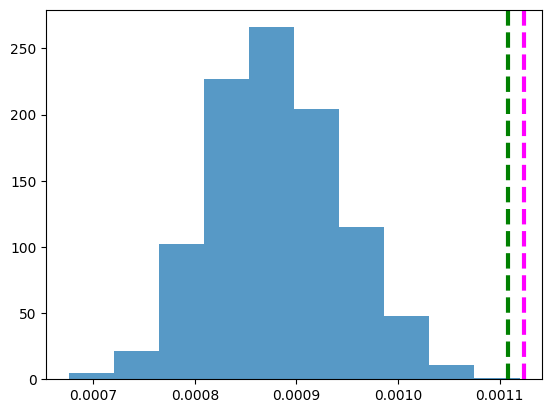

In [ ]:
plt.hist(avg_inf, alpha=0.75)
plt.axvline(average_influence[np.unique(l4_idx)][:,np.unique(l1_idx)].mean(), ls='--', lw=3, color='green')
plt.axvline(average_influence[np.unique(l4_idx_)][:,np.unique(l1_idx_)].mean(), ls='--', lw=3, color='magenta')
plt.savefig(datadir/'permutations_distribution_wSAE2.png')
plt.show()